<a href="https://colab.research.google.com/github/bi11-152vyl/Lung-CT-Scan-Deep-Learning-/blob/main/U_Net_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Techmaster - Image Segmentation - U-Net (framework Tensorflow)**


<center><img src='https://www.tensorflow.org/images/tf_logo_social.png' width="250"></center>

## **Phần I - Chuẩn bị dữ liệu**

### **1.1. Bộ dữ liệu để Huấn luyện mô hình Phân vùng ảnh**

- **Mạng U-Net**: Gồm 2 phần: Encoder và Decoder

<center><img src='https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png' width="750"></center>

- **Bộ dữ liệu**: Để đào tạo một mô hình Phân vùng ảnh với mạng U-Net, ta cần chuẩn bị nhiều ảnh huấn luyện (định dạng .jpg) kèm theo ảnh nhãn - gọi là mask (cũng ở định dạng .jpg). Một cặp hai ảnh huấn luyện và ảnh mask phải luôn luôn có cùng kích thước.

  - Tải bộ toàn bộ dữ liệu (cả dữ liệu Huấn luyện + Kiểm thử) [tại đây](https://www.kaggle.com/datasets/thezaza102/tray-food-segmentation?resource=download)

### **1.2. Tạo thư mục trên Google Drive**


- Trên Google Drive, các bạn tạo **thư mục** như sau:

<pre><code>
  UNet/
  ├───core/
  └───TrayDataset/
      ├───XTest/
      │   └───<b>Ảnh test</b> (định dạng .jpg)
      ├───XTrain/
      │   └───<b>Ảnh train</b> (định dạng .jpg)
      ├───yTest/
      │   └───<b>Mask nhãn tương ứng ảnh test trong folder XTest</b> (định dạng .jpg)
      └───yTrain/
          └───<b>Mask nhãn tương ứng ảnh train trong folder XTrain</b> (định dạng .jpg)
</pre>

## **Phần II - Các thiết lập trên Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.callbacks import LearningRateScheduler
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
%cd '/content/drive/MyDrive/Unet/TrayDataset'

image_path = sorted(os.listdir("/content/drive/MyDrive/Unet/TrayDataset/XTrain1"))
label_path = sorted(os.listdir("/content/drive/MyDrive/Unet/TrayDataset/yTrain1"))

/content/drive/MyDrive/Unet/TrayDataset


In [4]:
def load_images(inputdir, inputpath, imagesize):
    imglist = []
    
    for i in range(len(inputpath)):
        img = cv2.imread(inputdir+inputpath[i], cv2.IMREAD_COLOR) 
        img = cv2.resize(img, (imagesize, imagesize), interpolation = cv2.INTER_AREA)
        img = img[::-1] 
        imglist.append(img)
        
    return imglist

In [5]:
def segment(label, img_size):
    labels = []
    
    for i in range(len(label)):
        tmp = label[i].flatten()
        for j in range(len(tmp)):
            if tmp[j] > 10:
                tmp[j] = 200
                
        labels.append(tmp.reshape(img_size,img_size,3))
        
    return labels

In [6]:
IMAGE_SIZE = 128

image = load_images("./XTrain1/", image_path, IMAGE_SIZE)
before_label = load_images("./yTrain1/", label_path, IMAGE_SIZE)

after_label = segment(before_label, IMAGE_SIZE)

image /= np.max(image)
after_label /= np.max(after_label)

### **2.1. Khảo sát mẫu ảnh huấn luyện**

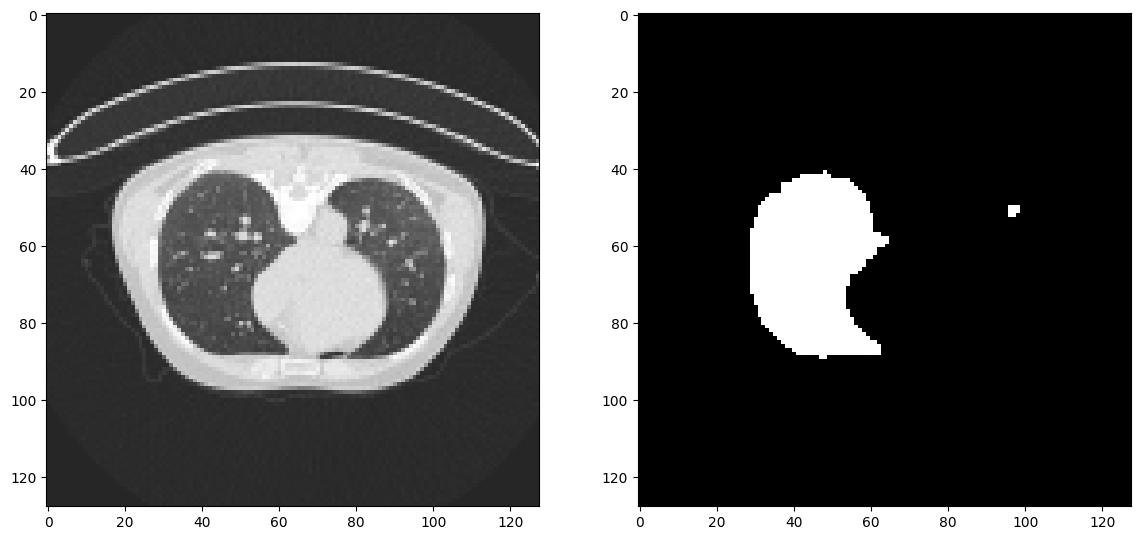

In [8]:
num = 1

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image[num]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(after_label[num]))

### **2.2. Khởi tạo Mô hình U-Net**

In [9]:
def Unet():
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(input_img)
    enc1 = BatchNormalization()(enc1)
    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(enc1)
    enc1 = BatchNormalization()(enc1)
    down1 = MaxPooling2D(pool_size=2, strides=2)(enc1)
    
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(down1)
    enc2 = BatchNormalization()(enc2)
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(enc2)
    enc2 = BatchNormalization()(enc2)
    down2 = MaxPooling2D(pool_size=2, strides=2)(enc2)

    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(down2)
    enc3 = BatchNormalization()(enc3)
    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(enc3)
    enc3 = BatchNormalization()(enc3)
    down3 = MaxPooling2D(pool_size=2, strides=2)(enc3)
    
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(down3)
    enc4 = BatchNormalization()(enc4)
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(enc4)
    enc4 = BatchNormalization()(enc4)
    down4 = MaxPooling2D(pool_size=2, strides=2)(enc4)
    
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(down4)
    enc5 = BatchNormalization()(enc5)
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(enc5)
    enc5 = BatchNormalization()(enc5)

    up4 = UpSampling2D(size=2)(enc5)
    dec4 = concatenate([up4, enc4], axis=-1)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    
    up3 = UpSampling2D(size=2)(dec4)
    dec3 = concatenate([up3, enc3], axis=-1)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)

    up2 = UpSampling2D(size=2)(dec3)
    dec2 = concatenate([up2, enc2], axis=-1)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    
    up1 = UpSampling2D(size=2)(dec2)
    dec1 = concatenate([up1, enc1], axis=-1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    
    dec1 = Conv2D(3, kernel_size=1, strides=1, activation="sigmoid", padding="same")(dec1)
    
    model = Model(inputs=input_img, outputs=dec1)
    
    return model

In [10]:
model = Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  512        ['conv2d[0][0]']                 
 alization)                     8)                                                            

### **2.3. Một số metrics đánh giá Mô hình**

In [11]:
def castF(x): 
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [13]:
def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = K.cast(K.greater_equal(y_pred, threshold), dtype='float32')
    correct_predictions = K.cast(K.equal(y_true, y_pred), dtype='float32')
    return K.mean(correct_predictions)


In [14]:
def f1_score(y_true, y_pred, threshold=0.5):
    y_pred = K.cast(K.greater_equal(y_pred, threshold), dtype='float32')
    tp = K.sum(K.cast(y_true * y_pred, dtype='float32'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, dtype='float32'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), dtype='float32'))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

In [15]:
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = K.cast(K.greater_equal(y_pred, threshold), dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
    return iou

### **2.4. Huấn luyện Mô hình**

In [16]:
X_train, X_val, T_train, T_val = train_test_split(image, after_label, test_size=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef, accuracy, f1_score, iou_score])

initial_learningrate=2e-3

def lr_decay(epoch):
    if epoch < 10:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch
    
training = model.fit(X_train, T_train,epochs=7, batch_size=12, shuffle=True, validation_data=(X_val, T_val), verbose=1,callbacks=[LearningRateScheduler(lr_decay,verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/7
3/3 [==============================] - 354s 116s/step - loss: 1.1479 - dice_coef: 0.0699 - accuracy: 0.4976 - f1_score: 0.0685 - iou_score: 0.0335 - val_loss: 197733.5156 - val_dice_coef: 3.5968e-05 - val_accuracy: 0.9337 - val_f1_score: 0.0000e+00 - val_iou_score: 5.0700e-11 - lr: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.002.
Epoch 2/7
3/3 [==============================] - 330s 110s/step - loss: 0.7473 - dice_coef: 0.0887 - accuracy: 0.5748 - f1_score: 0.1139 - iou_score: 0.0647 - val_loss: 294883776.0000 - val_dice_coef: 0.0735 - val_accuracy: 0.3356 - val_f1_score: 0.0734 - val_iou_score: 0.0373 - lr: 0.0020

Epoch 3: LearningRateScheduler setting learning rate to 0.002.
Epoch 3/7
3/3 [==============================] - 297s 96s/step - loss: 0.6517 - dice_coef: 0.0879 - accuracy: 0.6907 - f1_score: 0.1570 - iou_score: 0.0860 - val_loss: 225640112.0000 - val_dice_coef: 0.0696 - val_accu

In [18]:
model.save("best_model.h5")

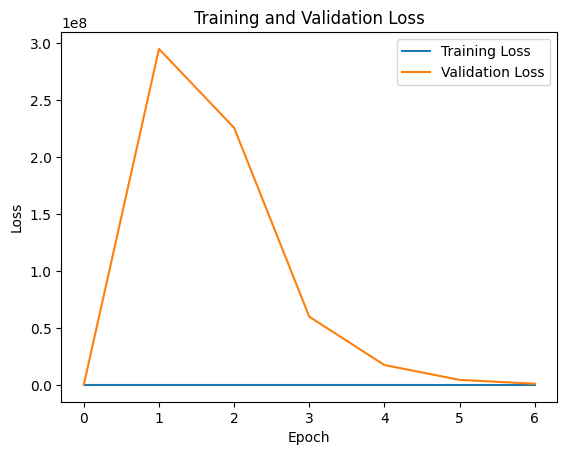

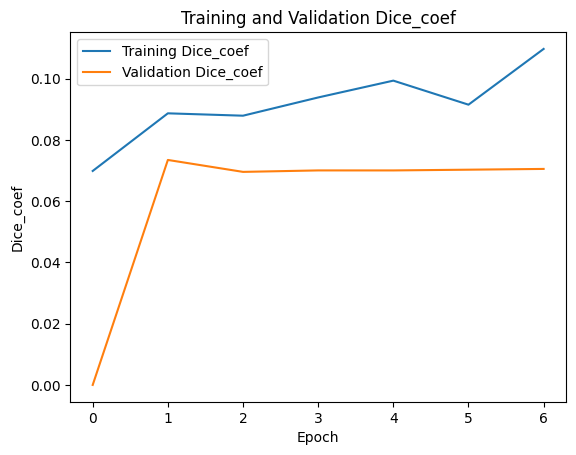

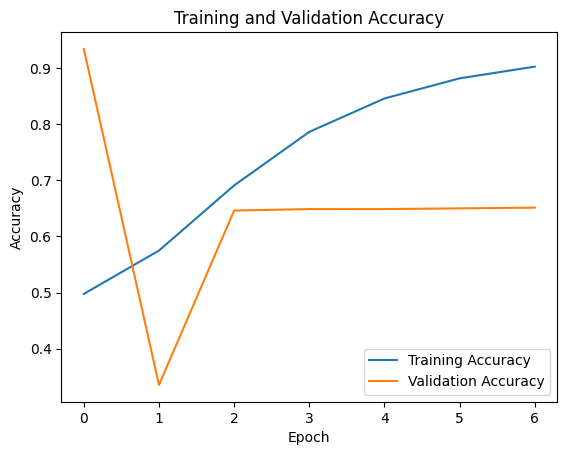

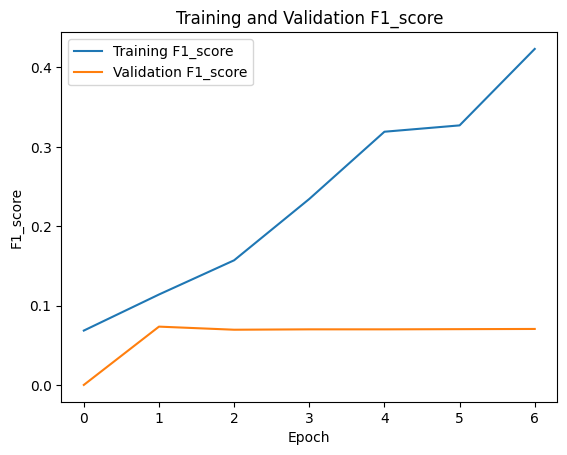

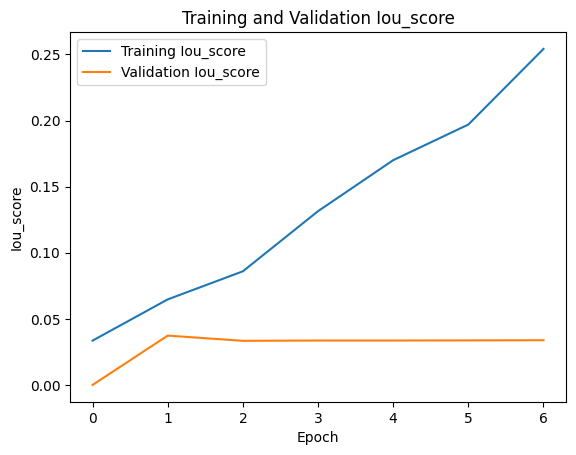

In [20]:
import matplotlib.pyplot as plt

history = training.history

# Plot the training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the dice coefficient, accuracy, f1 score, and IoU score for the training and validation sets
metrics = ['dice_coef', 'accuracy', 'f1_score', 'iou_score']
for metric in metrics:
    plt.plot(history[metric], label='Training ' + metric.capitalize())
    plt.plot(history['val_' + metric], label='Validation ' + metric.capitalize())
    plt.title('Training and Validation ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


### **2.5. Dự đoán**

In [21]:
test_path = os.listdir("./XTest1")
test_image = load_images("./XTest1/", test_path, IMAGE_SIZE)

test_image /= np.max(test_image)

results = model.predict(test_image,verbose=1)

1/1 [==============================] - 37s 37s/step


### **2.6. Hiển thị trực quan Kết quả**

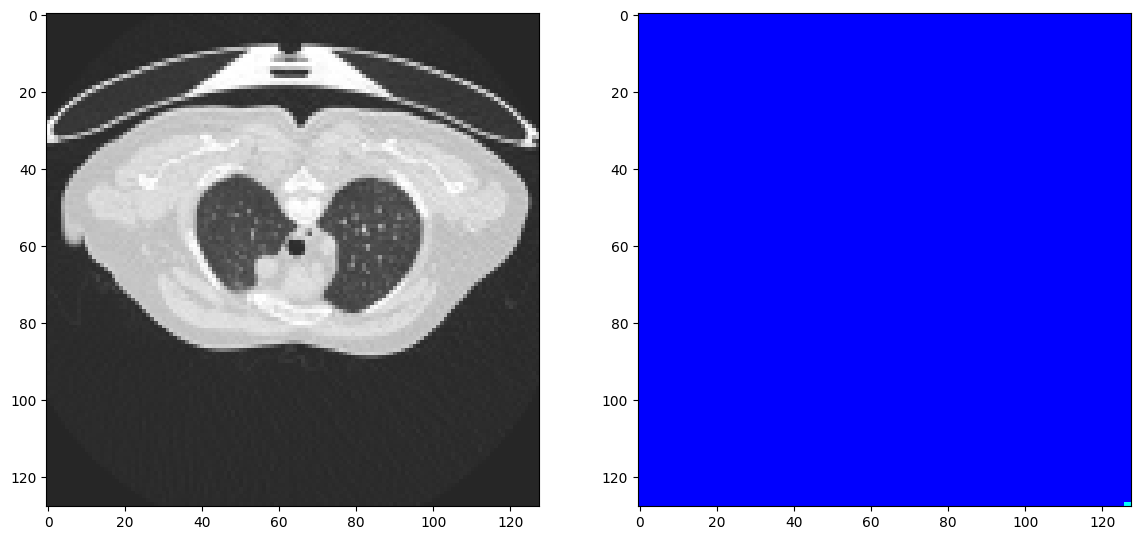

In [26]:
n = 7

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image[n]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(results[n]))

## **Phần III - Tham khảo U-Net trên framework khác**

Xây dựng mạng U-Net với Framework PyTorch [tại đây](https://colab.research.google.com/drive/1a-5Hu3MGN1M-vVTVJP024dCVz-6jgA0y?usp=sharing)